In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
table = read_csv('/content/drive/MyDrive/QuadrantiSchivenoglia.csv')
table.head()

Unnamed: 0        Date  Ammonia  PM10  PM25  Wind_speed  Temperature  \
0           0  2014-01-01     14.1  56.0  56.0    1.508213     4.766667   
1           1  2014-01-02     19.4  56.0  55.0    0.390941     5.479167   
2           2  2014-01-03     10.2  43.0  39.0    2.104680     5.766667   
3           3  2014-01-04      8.6  37.0  33.0    0.949083     6.950000   
4           4  2014-01-05      7.7  18.0  16.0    1.130128     7.541667   

   Rainfall  Quadrante  
0       0.2          3  
1       2.0          4  
2       1.4          3  
3       5.8          2  
4      14.2          3

In [4]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
#PM 2.5 were removed
Moggio = table.loc[:,["Date","PM10","Ammonia","Wind_speed","Quadrante","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:-365,:] # we train not using 2020, for now
Moggio.head()


index        Date  PM10  Ammonia  Wind_speed  Quadrante  Temperature  \
0      0  2014-01-01  56.0     14.1    1.508213          3     4.766667   
1      1  2014-01-02  56.0     19.4    0.390941          4     5.479167   
2      2  2014-01-03  43.0     10.2    2.104680          3     5.766667   
3      3  2014-01-04  37.0      8.6    0.949083          2     6.950000   
4      4  2014-01-05  18.0      7.7    1.130128          3     7.541667   

   Rainfall  
0       0.2  
1       2.0  
2       1.4  
3       5.8  
4      14.2

In [5]:
# sns.lineplot(x='Date', y='PM25', data=Moggio)

##Convert series to supervised learning
### Activation function = tanh and logistic (s curve)

###Conversion Function

In [6]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Conversion of Moggio

In [7]:
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[31,32,33,34,35]], axis=1, inplace=True)

reframed.head()

var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  var5(t-5)  var6(t-5)  \
5   0.327161   0.032745   0.178967   0.666667   0.562163   0.003846   
6   0.327161   0.045053   0.044953   1.000000   0.573684   0.038462   
7   0.246914   0.023688   0.250511   0.666667   0.578333   0.026923   
8   0.209877   0.019972   0.111901   0.333333   0.597467   0.111538   
9   0.092593   0.017882   0.133617   0.666667   0.607034   0.273077   

   var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  ...  var4(t-2)  var5(t-2)  \
5   0.327161   0.045053   0.044953   1.000000  ...   0.333333   0.597467   
6   0.246914   0.023688   0.250511   0.666667  ...   0.666667   0.607034   
7   0.209877   0.019972   0.111901   0.333333  ...   1.000000   0.638093   
8   0.092593   0.017882   0.133617   0.666667  ...   0.666667   0.613973   
9   0.141975   0.031584   0.207754   1.000000  ...   0.333333   0.619565   

   var6(t-2)  var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  \
5   0.111538   0.092593   0.017882   0.133617   0.666667   0.607034   
6   0.273077   0.141975   0.031584   0.207754   1.000000   0.638093   
7   0.000000   0.308642   0.033442   0.122895   0.666667   0.613973   
8   0.003846   0.228395   0.032745   0.085629   0.333333   0.619565   
9   0.000000   0.481481   0.034835   0.037766   1.000000   0.649344   

   var6(t-1)   var1(t)  
5   0.273077  0.141975  
6   0.000000  0.308642  
7   0.003846  0.228395  
8   0.000000  0.481481  
9   0.000000  0.376543  

[5 rows x 31 columns]

In [8]:
# split into train and test sets
values = reframed.values
n_features = 6 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1312, 30) 1312 (1312,)
(1312, 5, 6) (1312,) (66, 5, 6) (66,)


# Modeling and training

Epoch 1/500
14/14 - 6s - loss: 0.1130 - val_loss: 0.1038 - 6s/epoch - 420ms/step
Epoch 2/500
14/14 - 0s - loss: 0.0841 - val_loss: 0.0991 - 147ms/epoch - 11ms/step
Epoch 3/500
14/14 - 0s - loss: 0.0826 - val_loss: 0.0969 - 169ms/epoch - 12ms/step
Epoch 4/500
14/14 - 0s - loss: 0.0803 - val_loss: 0.0949 - 160ms/epoch - 11ms/step
Epoch 5/500
14/14 - 0s - loss: 0.0794 - val_loss: 0.0939 - 161ms/epoch - 11ms/step
Epoch 6/500
14/14 - 0s - loss: 0.0786 - val_loss: 0.0930 - 156ms/epoch - 11ms/step
Epoch 7/500
14/14 - 0s - loss: 0.0773 - val_loss: 0.0925 - 157ms/epoch - 11ms/step
Epoch 8/500
14/14 - 0s - loss: 0.0763 - val_loss: 0.0924 - 163ms/epoch - 12ms/step
Epoch 9/500
14/14 - 0s - loss: 0.0756 - val_loss: 0.0927 - 153ms/epoch - 11ms/step
Epoch 10/500
14/14 - 0s - loss: 0.0753 - val_loss: 0.0931 - 166ms/epoch - 12ms/step
Epoch 11/500
14/14 - 0s - loss: 0.0746 - val_loss: 0.0931 - 159ms/epoch - 11ms/step
Epoch 12/500
14/14 - 0s - loss: 0.0743 - val_loss: 0.0930 - 147ms/epoch - 11ms/step
Epo

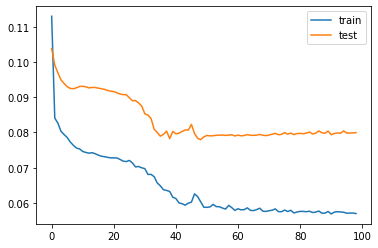

In [9]:
# design the neural network
model = Sequential()
model.add(LSTM(50, return_sequences=True, dropout = 0, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
early_stopping = EarlyStopping(patience=50, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs=500, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=early_stopping)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Predictions of the year 2019

In [10]:
# make a prediction
yhat = model.predict(test_X)
#Convert from 3D to 2D
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1) # the last 5 so that we have all 5 of the predictors in only one lag (and not all the 5 lags)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 16.505


#### Prediciton plots

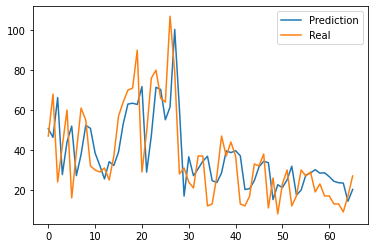

In [11]:
pyplot.plot(inv_yhat, label = 'Prediction')
pyplot.plot(inv_y, label = 'Real')
pyplot.legend()
pyplot.show()

prediction with 2020

In [12]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
#PM 2.5 were removed
Moggio = table.loc[:,["Date","PM10","Ammonia","Wind_speed","Quadrante","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:,:] # this is the differrence!!!!
Moggio.head()
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[31,32,33,34,35]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
n_features = 6 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(1312, 30) 1312 (1312,)
(1312, 5, 6) (1312,) (431, 5, 6) (431,)


In [13]:
# make a prediction
yhat = model.predict(test_X)
#Convert from 3D to 2D
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 13.161


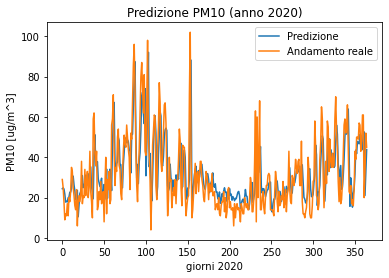

In [14]:
pyplot.plot(inv_yhat[-365:], label = 'Predizione')
pyplot.plot(inv_y[-365:], label = 'Andamento reale')
pyplot.legend()
pyplot.title("Predizione PM10 (anno 2020)")
pyplot.xlabel('giorni 2020') 
pyplot.ylabel('PM10 [ug/m^3]') 
pyplot.show()

# LIME

In [15]:
!pip install lime

     |████████████████████████████████| 275 kB 12.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=56c643cbb4b5389a5c6e6799a8883c561851e103931aacfeee93244cfe0e5dc9
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [16]:
from lime import lime_tabular

In [17]:
test_X.shape
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))


In [18]:
explainer = lime_tabular.RecurrentTabularExplainer(test_X, feature_names=["PM10","Ammonia","Wind_speed","Quadrante","Temperature","Rainfall"], mode='regression')

In [19]:
exp = explainer.explain_instance(test_X[50], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()
# values are the actual values of the features for that given day

In [20]:
test_X[49]

array([[0.18518518, 0.05945193, 0.09455648, 0.6666666 , 0.69286746,
        0.        ],
       [0.17901234, 0.08941013, 0.07959804, 0.6666666 , 0.71042943,
        0.        ],
       [0.21604939, 0.04366001, 0.21804324, 0.33333334, 0.7417356 ,
        0.        ],
       [0.04938272, 0.02972596, 0.1763565 , 0.33333334, 0.6779891 ,
        0.44615388],
       [0.1419753 , 0.01834649, 0.27501175, 0.        , 0.67149884,
        0.        ]], dtype=float32)

In [ ]:
exp = explainer.explain_instance(test_X[49], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [ ]:
exp = explainer.explain_instance(test_X[75], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [ ]:
test_X[1]

In [ ]:
exp.as_list()